In [1]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, in_channels, num_heads=8, head_dim=32, groups=32) -> None:
        super().__init__()
        self.scale = head_dim ** -0.5
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.q = nn.Conv2d(in_channels, num_heads * head_dim, kernel_size=1)
        self.k = nn.Conv2d(in_channels, num_heads * head_dim, kernel_size=1)
        self.v = nn.Conv2d(in_channels, num_heads * head_dim, kernel_size=1)
        self.norm = nn.GroupNorm(groups, in_channels)
        self.proj = nn.Conv2d(num_heads * head_dim, in_channels, kernel_size=1)

    def forward(self, x):
        B, _, H, W = x.shape
        q = self.q(x).view(B, self.num_heads, self.head_dim, H * W).permute(0, 1, 3, 2)
        k = self.k(x).view(B, self.num_heads, self.head_dim, H * W)
        v = self.v(x).view(B, self.num_heads, self.head_dim, H * W).permute(0, 1, 3, 2)

        attention = torch.softmax(torch.matmul(q, k) * self.scale, dim=-1)
        attention = torch.matmul(attention, v)
        attention = attention.permute(0, 1, 3, 2).contiguous().view(B, self.num_heads * self.head_dim, H, W)
        return self.norm(x + self.proj(attention))

In [ ]:
num_heads = 8
head_dim = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

q, k, v = torch.randn(3, 2, 64, 32, 32).to(device)

q_proj = nn.Conv2d(64, num_heads * head_dim, kernel_size=1).to(device)
k_proj = nn.Conv2d(64, num_heads * head_dim, kernel_size=1).to(device)
v_proj = nn.Conv2d(64, num_heads * head_dim, kernel_size=1).to(device)

B, _, H, W = q.shape

q = q_proj(q).view(B, num_heads, head_dim, H * W)
k = k_proj(k).view(B, num_heads, head_dim, H * W)
v = v_proj(v).view(B, num_heads, head_dim, H * W)


mha = nn.MultiheadAttention(embed_dim=head_dim * num_heads, num_heads=num_heads).to(device)
attn = mha(q, k, v, need_weights=False)



In [2]:
import torch
import pytorch_lightning as pl
from modules.models.autoencoder.vector_quantized_autoencoder import VQAutoencoder
from modules.data_module import DataModule

from omegaconf import OmegaConf

config = OmegaConf.load('./config/config.yaml')

ae = VQAutoencoder.load_from_checkpoint('./checkpoints/VQAutoencoder-epoch=299.ckpt')

dm = DataModule(
    **config.data,
    autoencoder=ae,
    use_latents=True,
    depth_as_channels=False, # has no effect when use_latent=False
    batch_size=10, 
    shuffle=True, 
    num_workers=8
)

dm.prepare_data()
dm.setup()
loader = dm.train_dataloader()

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Loading dataset from npy file...


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]

Scale: tensor(0.4810)
Latents standard deviation: tensor(1.)
Latents shape: torch.Size([10, 16, 128, 128])


In [2]:
b = next(iter(loader))

In [3]:
b[0].shape

torch.Size([16, 64, 64, 64])

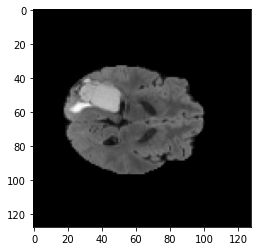

In [4]:
import matplotlib.pyplot as plt

plt.imshow(b[0][4, 0], cmap='gray')

In [5]:
ae = ae.to('cuda')
recon = ae(b[0].to('cuda', dtype=torch.float32), b[1].to('cuda'))

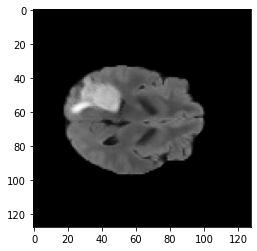

In [6]:
plt.imshow(recon[0][4, 0].detach().cpu().numpy(), cmap='gray')

In [12]:
pemb = ae.encode_position(b[1].to('cuda', dtype=torch.long))
z = ae.encode_pre_quantization(b[0].to('cuda', dtype=torch.float32), pemb)

In [14]:
z[0].shape

torch.Size([16, 4, 32, 32])